# Our original toy example...

In [1]:
from advectionGPdatasets import proposeboundary
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [2]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    if t<=-4.9: 
        v=0
    else:
        blobsize = np.sqrt(2*2*D*(t+5))+1 #normally +10, but making it narrow
        d = np.linalg.norm(np.array([x,y])-blobcentre)    
        v = 300*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [3]:
X = []
Y = []
D = 1 #almost no diffusion
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


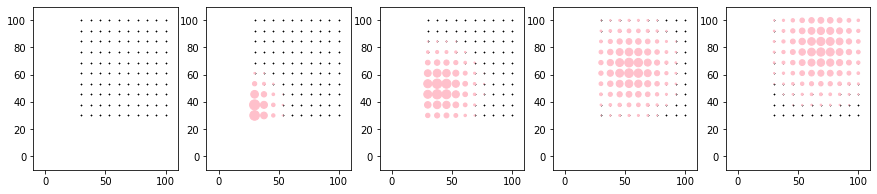

In [4]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [5]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [6]:
#set up our model...
N_feat = 500 #Number of features used to infer the source
k = EQ(20, 1)
res = [50,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

In [7]:
mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


In [8]:
Nsamps = 3
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...


In [9]:
#concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=5,Nparticles=25,interpolateSource=True)
scaleby = [8,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]]
concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=50,Zs=Zs,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(50, 7, 50, 50, 3)
Diffusing particles...


In [10]:
gridps = coords.transpose([1,2,3,0]).copy()
realconc = np.zeros(coords.shape[1:])
for i in np.ndindex(gridps.shape[:3]):
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

In [11]:
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

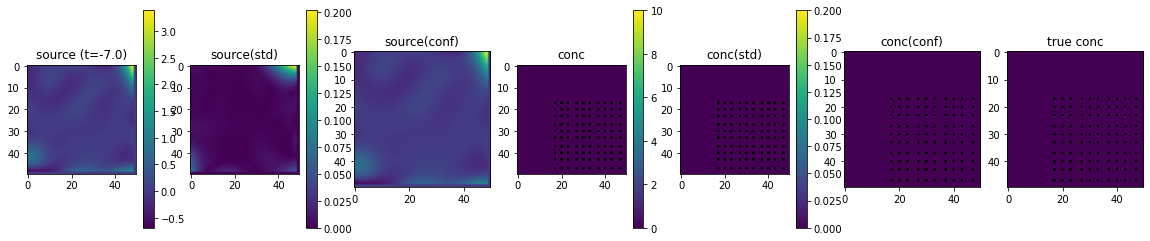

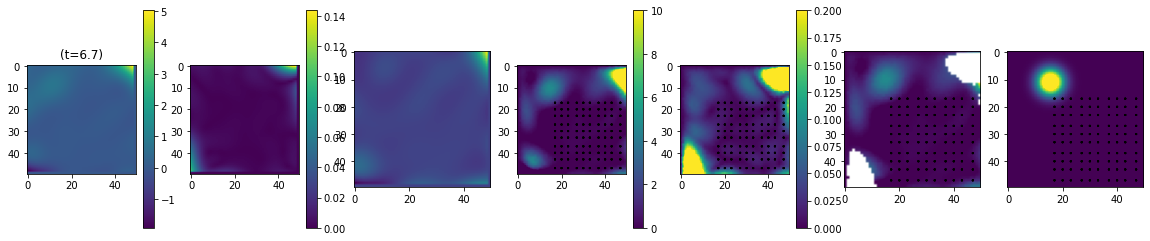

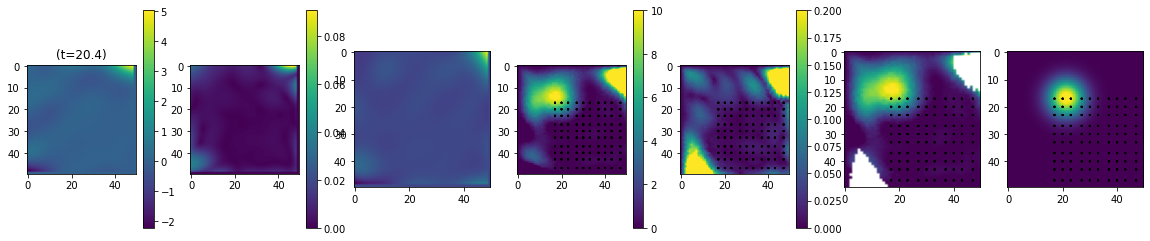

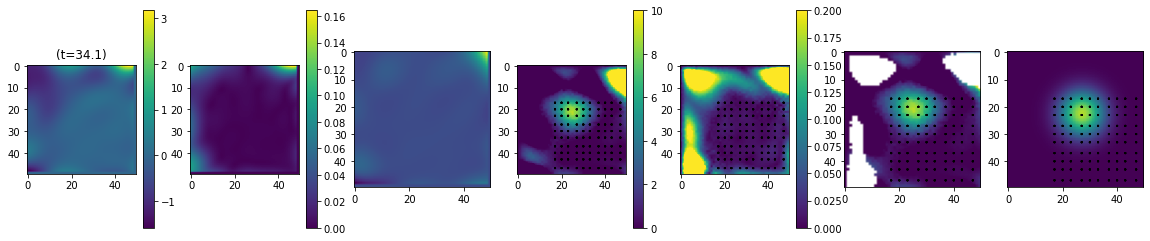

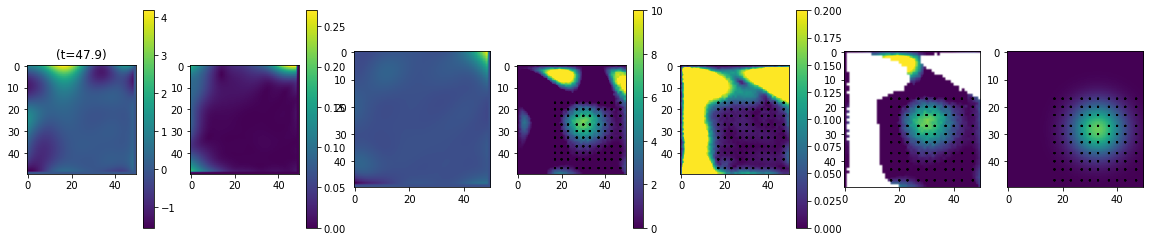

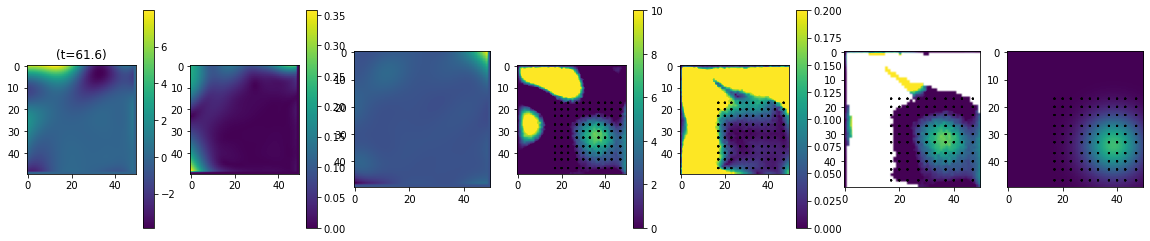

In [13]:
for tsamp in range(0,int(mInferCoords.shape[1]/scaleby[0]),1):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    t = mInferCoords[0,tsamp*scaleby[0],0,0]
    if tsamp==0: 
        plt.title('source (t=%0.1f)' % t)
    else:
        plt.title('(t=%0.1f)' % t)
    plt.imshow(sourcemean[tsamp*scaleby[0],:,:])
    plt.colorbar()
    #plt.clim([-1,1])
    
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('source(std)')
    plt.imshow(np.sqrt(sourcevar[tsamp*scaleby[0],:,:]))
    plt.colorbar()
    
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('source(conf)')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp*scaleby[0],:,:])<2
    plt.imshow(vals,alpha=alphas.astype(float))

    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(concmean[tsamp,:,:])
    plt.colorbar()
    plt.clim([0,10])
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('conc(std)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    plt.clim([0,0.2])
    plt.colorbar()
    

    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<0.15
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([0,10])
    
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('true conc')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(realconc[tsamp,:,:])
    plt.clim([0,10])

# Playing with vectors and stuff...

Just getting my head around the cholesky, planes, and how it all works,...

[1. 1.]


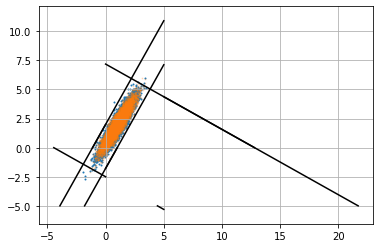

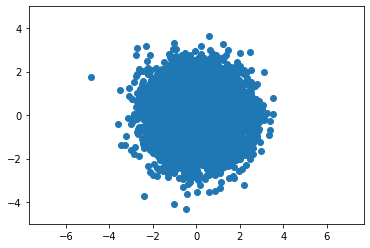

In [18]:
mean = np.array([1,2])
cov = np.array([[1.81,2.7],[2.7,4.81]])/4
rot = np.array([[0,1],[-1,0]])
prec = np.linalg.inv(cov)
#L = np.linalg.cholesky(cov)
Lprec = np.linalg.cholesky(prec)
Lcov = np.linalg.cholesky(cov)
Linvprec = np.linalg.inv(Lprec)
#unitr = np.random.randn(1000,2)

#compute samples
temp = np.random.multivariate_normal(mean,cov,10000)

#demo that the samples transformed by -mean and the L of the precision give the unit normal
unitr = (temp-mean)@Lprec 

#and one computes samples from the original dist...
temp2 = unitr@Lcov.T+mean

#how we handle a plane...
myvecA = []
myvecb = []
myvecA.append(prec[:,0])
myvecb.append(prec[:,0].T @ np.array([0,2]))
myvecA.append(prec[:,0])
myvecb.append(prec[:,0].T @ np.array([1,0]))
myvecA.append(prec[:,0]@rot)
myvecb.append((prec[:,0]@rot).T @ np.array([0,-2.5]))
myvecA.append(prec[:,0]@rot)
myvecb.append((prec[:,0]@rot).T @ np.array([3,5.5]))
myvecA = np.array(myvecA)
myvecb = np.array(myvecb)

np.set_printoptions(precision=2,suppress=True)
newvecA = myvecA @ Linvprec.T


plt.figure()
plt.scatter(temp[:,0],temp[:,1],1,alpha=1)
plt.scatter(temp2[:,0],temp2[:,1],1,alpha=0.2)
plt.axis('equal')
plt.grid()
for A,b in zip(myvecA,myvecb):
    plt.plot([b/A[0],0],[0,b/A[1]],'k-')
    plt.plot([(b+A[1]*5)/A[0],5],[-5,(b-A[0]*5)/A[1]],'k-')
plt.figure()
plt.scatter(unitr[:,0],unitr[:,1])

plt.axis('equal')
plt.xlim([-5,5])
plt.ylim([-5,5])
print(np.std(unitr,0))

# This is useful for later...

we need to know where we might start our sampling... we need somewhere where the source is all positive.

In [31]:
getamax(sourcemean[::scaleby[0],:,:])

(6, 0, 0)

In [34]:
#direction of maximum
def getamax(a):
    return np.unravel_index(a.argmax(), a.shape)

#maxsourceargs = getamax(sourcemean[::scaleby[0],:,:]) #coords of maximum

Phi = []
for i,phi in enumerate(mInfer.kernel.getPhi(coords)):
    Phi.append(phi)
Phi = np.array(Phi) #build all our Phi...

#get phi for these coordinates...
#phimaxz = np.array(list(mInfer.kernel.getPhi(coords[:,maxsourceargs[0],maxsourceargs[1],maxsourceargs[2]])))


# Hit And Run Sampling...

We ignore the mean and covariance of z at the moment, and just grab samples that result in positive sources.

In [47]:
from hitandrun.hitandrun import HitAndRun
from hitandrun.polytope import Polytope
A = -Phi.reshape([Phi.shape[0],np.prod(Phi.shape[1:])]).T.astype(np.float64)
A = np.r_[A,phimaxz[None,:]]
b = np.zeros(len(A)).astype(np.float64)
b[-1]=2

ws = mInfer.kernel.W.copy()
for i in range(10):
    a = np.argmin(np.sum(ws**2,1))
    x0 = np.zeros(mInfer.kernel.W.shape[0])
    x0[a] = np.sign(np.mean(Phi[a,:,:,:]))
    if np.min(Phi.transpose([1,2,3,0])@x0)>0: break
    ws[a]=np.inf
    if i==9: print("Can't find single basis to start on axis of. Need to implement more complex search for start.")

polytope = Polytope(A=A, b=b) #Ax <= b

hitandrun = HitAndRun(polytope=polytope, starting_point=x0,thin=1)
samples = hitandrun.get_samples(n_samples=5)
checks = samples @ polytope.A.T - b
assert(np.alltrue(checks < 0))

hit-and-run steps:: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Plot some of the samples...

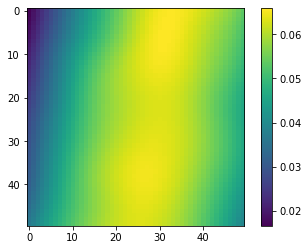

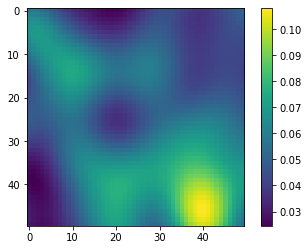

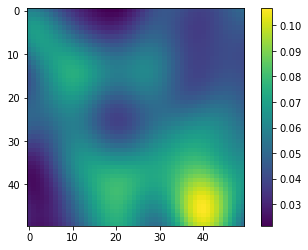

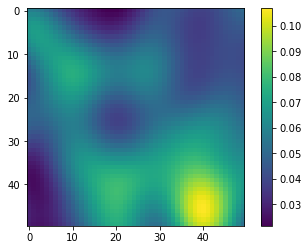

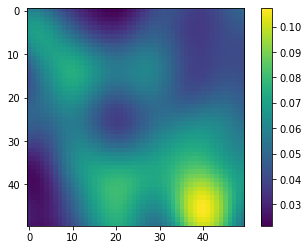

In [49]:
for s in (samples)[:,:]:
    plt.figure()
    plt.imshow((Phi.transpose([1,2,3,0])@s)[4,:,:])
    plt.colorbar()

# Hit and run again

In this example I try and do the sampling in the unit normal space (then project back to the space for p(q)).

In [52]:
from hitandrun.hitandrun import HitAndRun
from hitandrun.polytope import Polytope
A = -Phi.reshape([Phi.shape[0],np.prod(Phi.shape[1:])]).T.astype(np.float64)
A = np.r_[A,phimaxz[None,:]]

L = np.linalg.cholesky(covZ)
invL = np.linalg.inv(L)
#L => LL^T = cov
#invL.T ==> (invL.T)(invL.T).T = prec
#a point is transformed to unit normal space by multiplying by invL.T
#our vector for each plane is transformed by multiply by L
A = (A@L)
b = A@(-(meanZ@invL.T)) #places all planes to cross -mean
b[-1] = A[-1,:]@((phimaxz-meanZ)@invL.T)

ws = mInfer.kernel.W.copy()
for i in range(10):
    a = np.argmin(np.sum(ws**2,1))
    x0 = np.zeros(mInfer.kernel.W.shape[0])
    x0[a] = np.sign(np.mean(Phi[a,:,:,:]))
    if np.min(Phi.transpose([1,2,3,0])@x0)>0: break
    ws[a]=np.inf
    if i==9: print("Can't find single basis to start on axis of. Need to implement more complex search for start.")        
        
x0 = (x0-meanZ)@invL.T

polytope = Polytope(A=A, b=b) #Ax <= b

hitandrun = HitAndRun(polytope=polytope, starting_point=x0,thin=5)
samples = hitandrun.get_samples(n_samples=3)
checks = samples @ polytope.A.T - b
assert(np.alltrue(checks < 0))

hit-and-run steps:: 100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


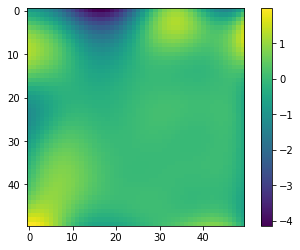

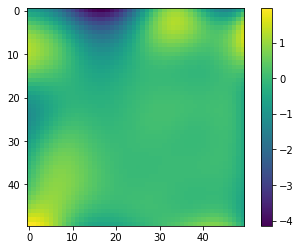

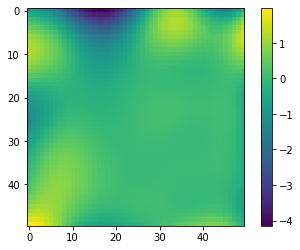

In [53]:
for s in (samples@L.T)[:,:]:
    plt.figure()
    plt.imshow((Phi.transpose([1,2,3,0])@s)[4,:,:])
    plt.colorbar()

argh, negatives -> got something horribly wrong

# Trying to memory optimise...

I think we don't need many locations, so maybe don't need to worry about this. (left it for if it's useful later)

In [90]:
coords.shape

(3, 7, 50, 50)

(7, 50, 50)


In [109]:
coords.reshape([3,np.prod(coords.shape[1:])])[:,0]

array([ -7., -10., -10.])

In [101]:
coords[:,0,0,0]

array([ -7., -10., -10.])

In [110]:
for a in coords.reshape([3,np.prod(coords.shape[1:])]).T:
    print(a)
    break

[ -7. -10. -10.]


In [ ]:
for c in coords:
    phi=norm*np.sqrt(2*self.sigma2)*np.cos(np.einsum('i,i...->...',self.W/self.l2,c)+ self.b)
    yield phi
    

def getPhiTranspose(self,coords):
    """
    For each point in coords, returns a vector of length of basis evaluated at each point.
    Arguments:
        coords: map of all (t,x,y) points in the grid
    """
    assert self.W is not None, "Need to call generateFeatures before computing phi."
    norm = 1./np.sqrt(self.N_feat)

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    ####c=1/(self.l2)
    for c in coords:
        phi=norm*np.sqrt(2*self.sigma2)*np.cos(np.einsum('i,i...->...',self.W/self.l2,c)+ self.b)
        yield phi            
            
    